<div class="head0">
    <div class="head0__name">
        Diffusion equation with linear drift in 1D case
    </div>
    <div class="head0__note">
        Solution of the 1D Fokker-Planck equation with linear drift (Ornstein–Uhlenbeck process) by fast and accurate tensor based method.
    </div>
</div>

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.extend(['./../lib', './../helpers'])
from solver import Solver as Solver
from helpers import init_jupyter; init_jupyter()

Start |  3:27PM MSK on Sep 04, 2019 |
-------------------------------------


<div class="head1">
    <div class="head1__name">
        Model problem
    </div>
</div>

Let solve
$$
    d x = f(x, t) \, dt + I \, d \beta,
    \quad
    \frac{\partial \rho}{\partial t} =
        \frac{1}{2} \Delta \rho -
        div \left[ f(x, t) \rho \right],
$$
where
$$
    \rho(x, 0) = \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]},
$$
$$
    f(x, t) = A \left( \mu - x(t) \right),
$$
where $A > 0$ is the velocity and $\mu$ ($\mu \equiv 0$ below) is the long-term mean.

Accurate computations leads to the following analytic solution
$$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
            }
        \exp{\left[
            - \frac
                {
                    x^2
                }
                {
                    2 \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        \right]},
$$
and stationary solution ($t \rightarrow \infty$)
$$
    \rho_{\infty}(x) =  
        \sqrt{
            \frac{A}{\pi}
        }
        e^{-A x^2},
$$
where
$$
    \Sigma(t) = \frac{1 - e^{-2 A t}}{2 A}.
$$

In [2]:
A = 1.
s = 1.
Dc = 0.5

def func_f0(x, t):
    m = 0.
    return A * (m - x)

def func_f1(x, t):
    return -A * np.ones(x.shape)

def func_xm(t, x0):
    return np.exp(-A * t) * x0
 
def func_xc(t):
    return (1. - np.exp(-2. * A * t)) / 2. / A

def func_r0(x):
    m = 0.
    r = np.exp(-0.5 * (x - m)**2 / s) / np.sqrt(2. * np.pi * s)
    return r.reshape(-1)

def func_rx(x, t, x0):
    m = func_xm(t, x0)
    c = func_xc(t)
    r = np.exp(-0.5 * (x - m)**2 / c) / np.sqrt(2. * np.pi * c)
    return r.reshape(-1)

def func_rt(x, t):
    S = func_xc(t) + s * np.exp(-2. * A * t)
    r = np.exp(-0.5 * x**2 / S) / np.sqrt(2. * np.pi * S)
    return r.reshape(-1)

def func_rs(x):
    r = np.sqrt(A / np.pi) * np.exp(- A * x * x)
    return r.reshape(-1)

<div class="head1">
    <div class="head1__name">
        Parameters
    </div>
</div>

In [3]:
t_poi = 1000
t_min = 0.
t_max = 3.0

x_poi = 100
x_min = -5.
x_max = +5.

<div class="head1">
    <div class="head1__name">
        Solution by the solver
    </div>
</div>

In [4]:
SL = Solver(d=1, ord=2)
SL.set_grid_t(t_poi, t_min, t_max, t_hst=10)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL.set_coefs(Dc)
SL.prep()
SL.calc()

Solve: 100%|█| 999/999 [00:03<00:00, 283.87step/s, | At T = 3.00e+00 : error = 1.30e-03]


<div class="head2">
    <div class="head2__name">
        Solution near boundaries
    </div>
    <div class="head2__note">
        Analytic solution is not vanish on the boundaries at selected time interval (but stationary solution will be zero), so we could not expect very good accuracy of our solver.
    </div>
</div>

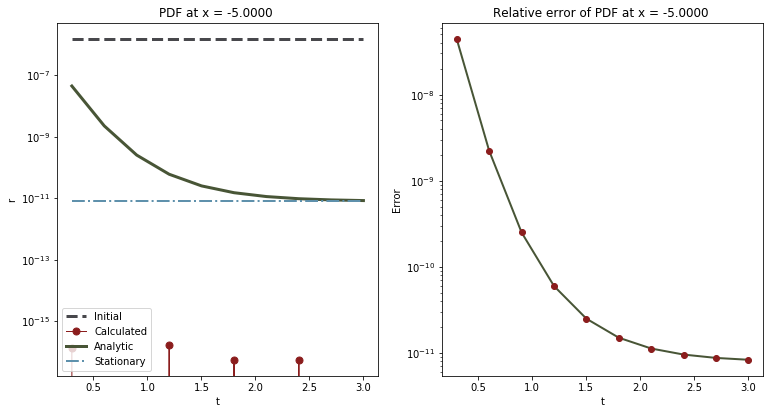

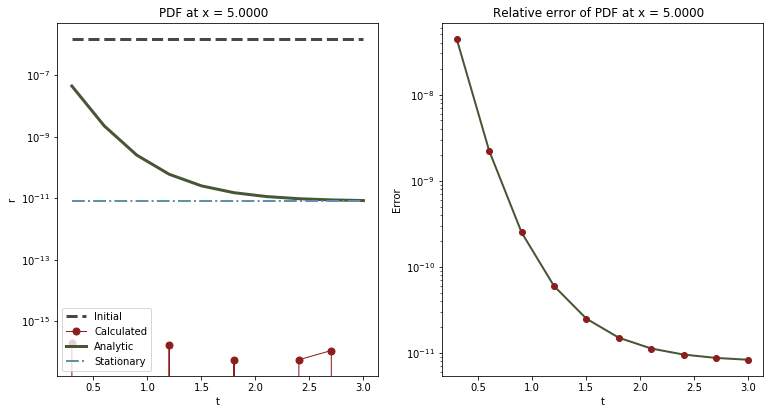

In [5]:
SL.plot_t(x=x_min, is_log=True, with_err_stat=True)
SL.plot_t(x=x_max, is_log=True, with_err_stat=True)

<div class="head2">
    <div class="head2__name">
        Solution in the inner points
    </div>
    <div class="head2__note">
        Solution is rather accurate.
    </div>
</div>

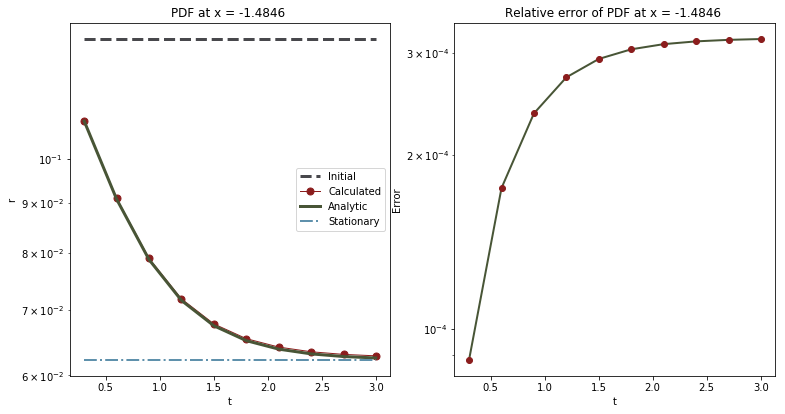

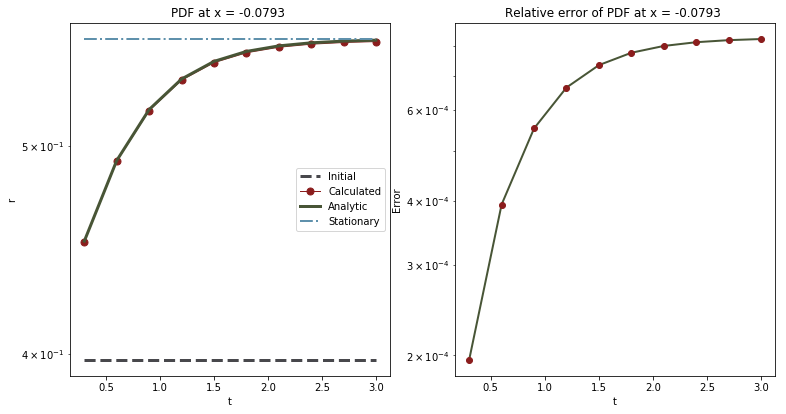

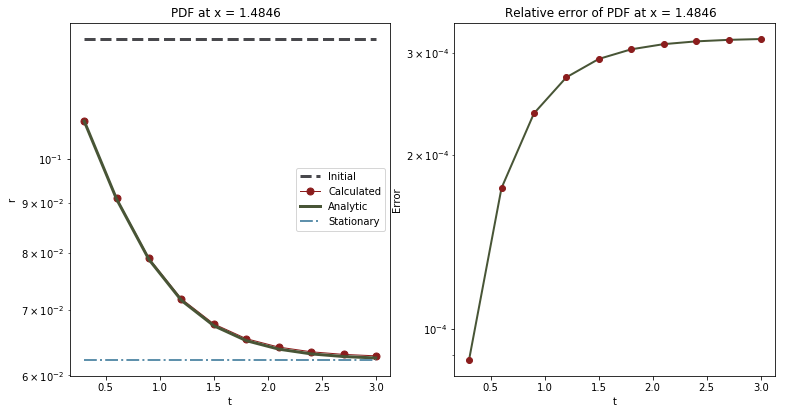

In [6]:
SL.plot_t(x=-1.5, is_log=True, with_err_stat=True)
SL.plot_t(x=+0.0, is_log=True, with_err_stat=True)
SL.plot_t(x=+1.5, is_log=True, with_err_stat=True)

<div class="head2">
    <div class="head2__name">
        Solution for different time steps
    </div>
    <div class="head2__note">
        Solution is not accurate at the final time step since analytic solution is not vanish on the boundaries.
    </div>
</div>

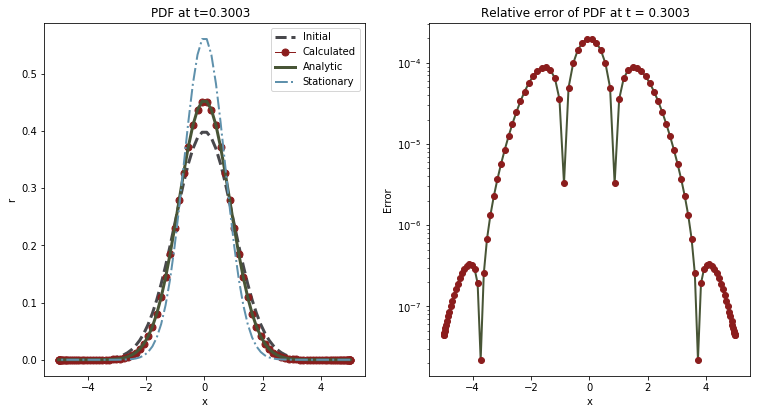

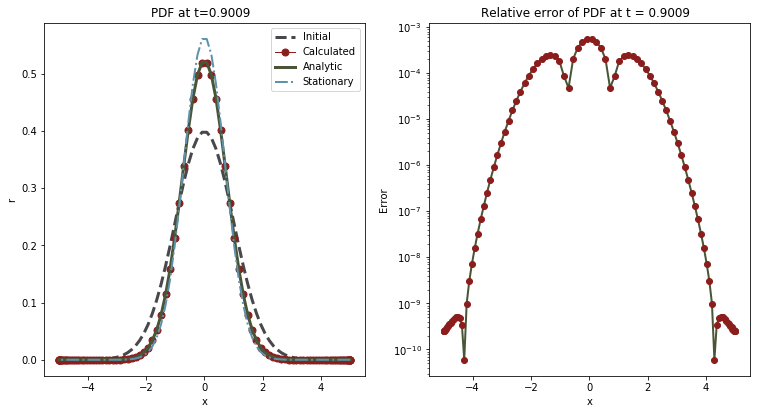

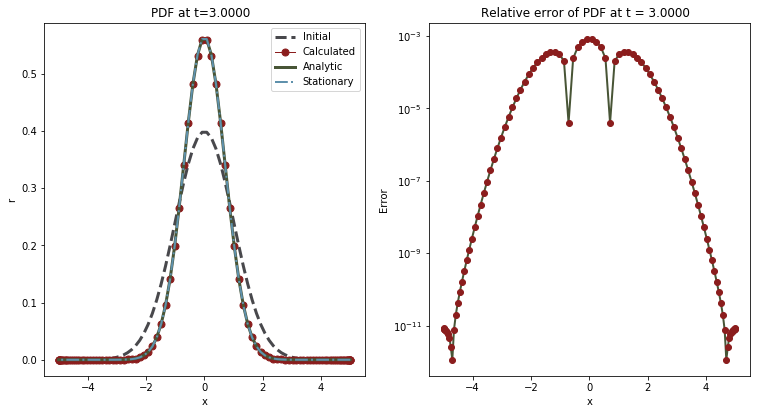

In [7]:
SL.plot_x(t=0.3)
SL.plot_x(t=0.9)
SL.plot_x()

<div class="head1">
    <div class="head1__name">
        Accuracy vs number of spatial points
    </div>
</div>

In [8]:
m = 1000
N = [10, 50, 100, 200]
Times = []
Errors = []

for n in N:
    SL = Solver(d=1, ord=2)
    SL.set_grid_t(m, t_min, t_max, t_hst=1)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.set_coefs(Dc)
    SL.prep()
    SL.calc()
    Times.append([SL._t_prep, SL._t_calc, SL._t_spec])
    Errors.append(SL._err)

Solve: 100%|█| 999/999 [00:07<00:00, 130.90step/s, | At T = 3.00e+00 : error = 1.30e-03]


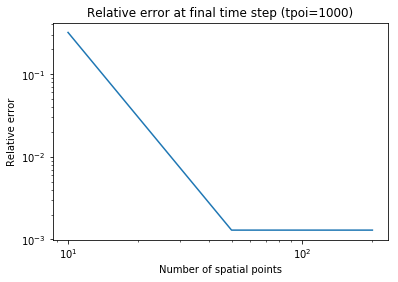



Solver info for n = 200, m = 1000 : 
----------- Solver
Format    : 1D, NP [order=2]
Grid x    : poi =       200, min =   -5.0000, max =    5.0000
Grid t    : poi =      1000, min =    0.0000, max =    3.0000 , hst =         1
Time sec  : prep = 4.74e-02, calc = 7.56e+00, spec = 1.57e+09
Rel.err.  : 1.30e-03


In [9]:
plt.plot(N, Errors)
plt.semilogx()
plt.semilogy()
plt.title('Relative error at final time step (tpoi=%d)'%m)
plt.xlabel('Number of spatial points')
plt.ylabel('Relative error')
plt.show()

print('\n\nSolver info for n = %d, m = %d : '%(N[-1], m))
SL.info()

<div class="head1">
    <div class="head1__name">
        Accuracy vs number of time points
    </div>
</div>

In [10]:
n = 100
M = [10, 100, 1000, 5000, 10000]
Times = []
Errors = []

for m in M:
    SL = Solver(d=1, ord=2)
    SL.set_grid_t(m, t_min, t_max, t_hst=1)
    SL.set_grid_x(n, x_min, x_max)
    SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SL.set_coefs(Dc)
    SL.prep()
    SL.calc()
    Times.append([SL._t_prep, SL._t_calc, SL._t_spec])
    Errors.append(SL._err)

Solve: 100%|█| 9999/9999 [00:38<00:00, 258.71step/s, | At T = 3.00e+00 : error = 1.30e-04]


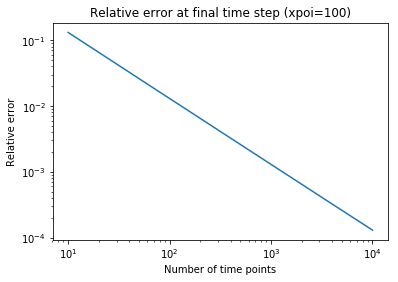



Solver info for n = 10000, m = 100 : 
----------- Solver
Format    : 1D, NP [order=2]
Grid x    : poi =       100, min =   -5.0000, max =    5.0000
Grid t    : poi =     10000, min =    0.0000, max =    3.0000 , hst =         1
Time sec  : prep = 7.72e-03, calc = 3.82e+01, spec = 1.57e+09
Rel.err.  : 1.30e-04


In [11]:
plt.plot(M, Errors)
plt.semilogx()
plt.semilogy()
plt.title('Relative error at final time step (xpoi=%d)'%n)
plt.xlabel('Number of time points')
plt.ylabel('Relative error')
plt.show()

print('\n\nSolver info for n = %d, m = %d : '%(M[-1], n))
SL.info()

<div class="head1">
    <div class="head1__name">
        Explicit solution
    </div>
    <div class="head1__note">
        Only for example.
    </div>
</div>

In [12]:
import time
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm

from intertrain import Intertrain

In [13]:
m = t_poi
n = x_poi
l = (x_max - x_min) / x_poi
h = (t_max - t_min) / (t_poi - 1)
T = np.linspace(t_min, t_max, t_poi)

def show_x(X, r_calc, _time):
    X = X.reshape(1, -1)
    r_init = func_r0(X.reshape(1, -1))
    r_real = func_rt(X.reshape(1, -1), t_max)
    r_stat = func_rs(X.reshape(1, -1))
    e = np.linalg.norm(r_real - r_calc) / np.linalg.norm(r_real)

    plt.plot(
        X.reshape(-1), r_init, '--', label='Initial',
        linewidth=3, color='tab:blue'
    )
    plt.plot(
        X.reshape(-1), r_calc, label='Calculated',
        linewidth=1, color='tab:green', marker='o', markersize=7,
        markerfacecolor='lightgreen', markeredgecolor='g'
    )
    plt.plot(
        X.reshape(-1), r_real, label='Analytic',
        linewidth=3, color='black'
    )
    plt.plot(
        X.reshape(-1), r_stat, '--', label='Stationary',
        linewidth=2, color='magenta'
    )
    
    plt.title('Solution at final time step')
    plt.xlabel('x')
    plt.ylabel('r')
    plt.legend(loc='best')
    plt.show()

    print('Number of spatial points : %8d'%x_poi)
    print('Number of time points    : %8d'%t_poi)
    print('Error (relative norm)    : %-12.2e'%e)
    print('Total time (sec)         : %-12.2e'%_time)

<div class="head2">
    <div class="head2__name">
        Euler solver and uniform spatial grid
    </div>
</div>

We can solve this 1D equation on the uniform spatial grid for the time $t > 0$ with step $h$ and uniform spatial grid with step $l$ using 2th order finite difference scheme

$$
    \frac{\partial \rho}{\partial t} = (D + \widehat{Q}) \rho,
$$
where
$$
    \widehat{Q} \rho = f Q \rho - \frac{\partial f}{\partial x} \rho,
$$

$$
    D = \frac{1}{l^2} tridiag \left( 1, -2, 1 \right),
    \quad
    Q = \frac{1}{2 l} tridiag \left( -1, 0, 1 \right).
$$

Let apply 1th order splitting method on the time step $(k+1)$
$$
    \frac{\partial v}{\partial t} = D v,
    \quad
    v_{k} = \rho_{k},
    \quad
    v_{k+1} = v = ?,
$$
$$
    \frac{\partial w}{\partial t} = \widehat{Q} w,
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = \rho_{k+1} = ?,
$$
and solve both ODE by the 1th order Euler method.

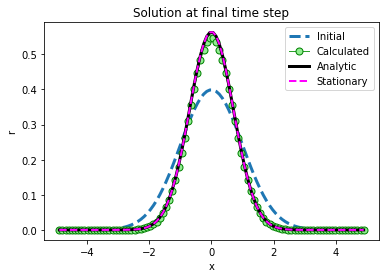

Number of spatial points :      100
Number of time points    :     1000
Error (relative norm)    : 2.92e-02    
Total time (sec)         : 1.29e-01    


In [14]:
_time = time.time()

X = np.linspace(x_min, x_max, x_poi).reshape(1, -1)[:, 1:-1]
Q = sp.spdiags([ [-1.]*n, [1.]*n ], [-1,  1], n, n).tocsr() 
Q = (Q / 2 / l).toarray()[1:-1, 1:-1]
D = sp.spdiags([ [1.]*n, [-2.]*n, [1.]*n ], [-1, 0, 1], n, n).tocsr() 
D = (D / l / l).toarray()[1:-1, 1:-1]
D = Dc * D

# ZD = expm(h * D)

r = func_r0(X.reshape(1, -1)).reshape(-1, 1)
for t in T[1:]:
    F0 = np.diag(func_f0(X, t).reshape(-1))
    F1 = np.diag(func_f1(X, t).reshape(-1))
    w0 = r
    w1 = w0 + h * D @ w0
    # w1 = ZD @ w0
    v0 = w1
    v1 = v0 - h * F0 @ Q @ v0 - h * F1 @ v0
    r = v1
    
show_x(X, r.reshape(-1), time.time() - _time)

<div class="end"></div>